# LSI Word Embedding using K-means, Gaussian Mixture and Cosine Similarity as Clustering

In [17]:
import os.path

from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
import re

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

from tqdm.notebook import tqdm, tnrange
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

In [18]:
# Download if not downloaded
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')

In [19]:
pd.set_option('display.max_rows', 200)
plt.rcParams['figure.figsize'] = [17, 6]
plt.rcParams.update({'font.size': 12})

In [20]:
%%html
<style>
table {float:center}
</style>

# Read and Merge Data

##### Ticker to GICS (version 1)

- data from prof (bloomberg)

In [21]:
# ticker_to_gics_df = pd.read_csv('data_out/ticker_to_gics_bloomberg.csv')
# ticker_to_gics_df.Ticker = ticker_to_gics_df.Ticker.str.replace('/','-')
# ticker_to_gics_df

##### Ticker to GICS (version 2 - better)

- data from previous code (not sure where origin)
- more data

In [22]:
ticker_to_gics_df = pd.read_csv('data_in/ticker_to_gics.csv', names=['Ticker', 'GICS'])
ticker_to_gics_df.Ticker = ticker_to_gics_df.Ticker.str.replace('/','-')
ticker_to_gics_df.GICS = ticker_to_gics_df.GICS.apply(lambda x: str(x)[:6])
ticker_to_gics_df.GICS = pd.Categorical(ticker_to_gics_df.GICS)
ticker_to_gics_df

,Ticker,GICS
0,A,352030
1,AA,151040
2,AAL,203020
3,AAN,255040
4,AAOI,452010
...,...,...
2959,ZTS,352020
2960,ZUMZ,255040
2961,ZUO,451030
2962,ZYNE,352020


### Helper functions

In [84]:
# For testing purposes
def longest_and_shortest_description(df):
    desc_len = df.Description.map(lambda s: len(s))
    max_i, max_n = desc_len.idxmax(), desc_len.max()
    min_i, min_n = desc_len.idxmin(), desc_len.min()
    print("LONGEST DESCRIPTION:")
    print(df.iloc[max_i].Description)
    print("SHORTEST DESCRIPTION:")
    print(df.iloc[min_i].Description)
    
def mean_and_median_description_length(df):
    desc_len = df.Description.map(lambda s: len(s))
    print('MEAN: %d'%desc_len.mean())
    print('MEDIAN: %d'%desc_len.median())

### SnP Data

##### SnP Descriptions (from 10K)

In [28]:
snp_desc_10K_df = pd.read_pickle('data_out/snp_desc_10K.pkl')

In [29]:
snp_desc_10K_df = pd.merge(snp_desc_10K_df, ticker_to_gics_df, on='Ticker')
snp_desc_10K_df = snp_desc_10K_df[['Ticker', 'Description', 'GICS']]

In [32]:
snp_desc_10K_df.head()

,Ticker,Description,GICS
0,AAL,PART I ITEM 1. BUSINESS Overview American ...,203020
1,AAPL,PART I Item 1.Business Company Background T...,452020
2,AAP,PART I Item 1. Business. Unless the context ...,255040
3,ABBV,PART I ITEM 1. BUSINESS Overview AbbVie(1) ...,352010
4,ABC,PART I ITEM 1. BUSINESS As used herein the ...,351020


In [33]:
snp_desc_10K_df.shape

(411, 3)

In [31]:
print(len(set(snp_desc_10K_df.GICS)))

60


##### SnP Descriptions (from yahoo)

In [23]:
snp_desc_yahoo_df = pd.read_csv('scrapy_spiders/data_out/snp_desc_yahoo.csv').dropna().reset_index(drop=True)

snp_desc_yahoo_df = pd.merge(snp_desc_yahoo_df, ticker_to_gics_df, on='Ticker')

snp_desc_yahoo_df.Industry = pd.Categorical(snp_desc_yahoo_df.Industry)
snp_desc_yahoo_df.Sector = pd.Categorical(snp_desc_yahoo_df.Sector)

In [24]:
snp_desc_yahoo_df.head()

,Ticker,Description,Sector,Industry,GICS
0,ABT,"Abbott Laboratories discovers, develops, manuf...",Healthcare,Medical Devices,351010
1,ABBV,"AbbVie Inc. discovers, develops, manufactures,...",Healthcare,Drug Manufacturers—General,352010
2,ADBE,Adobe Inc. operates as a diversified software ...,Technology,Software—Infrastructure,451030
3,MMM,"3M Company develops, manufactures, and markets...",Industrials,Specialty Industrial Machinery,201050
4,AMD,"Advanced Micro Devices, Inc. operates as a sem...",Technology,Semiconductors,453010


In [25]:
snp_desc_yahoo_df.shape

(499, 5)

In [26]:
print(len(set(snp_desc_yahoo_df.GICS)))
print(len(set(snp_desc_yahoo_df.Sector)))
print(len(set(snp_desc_yahoo_df.Industry)))

63
11
113


In [34]:
len([t for t in snp_desc_yahoo_df.Ticker if t not in list(snp_desc_10K_df.Ticker)])

129

- There seems to be alot of non-overlapping tickers in both snp data

##### SnP Descriptions (from Wiki)

In [35]:
snp_desc_wiki_df = pd.read_csv('data_out/snp_desc_wiki_df.csv')

In [36]:
snp_desc_wiki_df = pd.merge(snp_desc_wiki_df, ticker_to_gics_df, on='Ticker')
snp_desc_wiki_df = snp_desc_wiki_df[['Ticker', 'Description', 'GICS']]

In [37]:
snp_desc_wiki_df.head()

,Ticker,Description,GICS
0,MMM,The 3M Company is an American multinational co...,201050
1,ABT,Abbott Laboratories is an American multination...,351010
2,ABBV,AbbVie is an American publicly traded biopharm...,352010
3,ABMD,Abiomed is a publicly-traded medical devices c...,351010
4,ACN,Accenture plc is a multinational professional ...,451020


In [38]:
snp_desc_wiki_df.shape

(500, 3)

In [39]:
print(len(set(snp_desc_wiki_df.GICS)))

63


In [85]:
mean_and_median_description_length(snp_desc_wiki_df)

MEAN: 858
MEDIAN: 707


In [62]:
longest_and_shortest_description(snp_desc_wiki_df)

LONGEST DESCRIPTION:
Apple Inc. is an American multinational technology company headquartered in Cupertino, California, that designs, develops and sells consumer electronics, computer software, and online services. It is considered one of the Big Tech technology companies, alongside Amazon, Google, Microsoft, and Facebook.The company's hardware products include the iPhone smartphone, the iPad tablet computer, the Mac personal computer, the iPod portable media player, the Apple Watch smartwatch, the Apple TV digital media player, the AirPods wireless earbuds and the HomePod smart speaker. Apple's software includes macOS, iOS, iPadOS, watchOS, and tvOS operating systems, the iTunes media player, the Safari web browser, the Shazam music identifier and the iLife and iWork creativity and productivity suites, as well as professional applications like Final Cut Pro, Logic Pro, and Xcode. Its online services include the iTunes Store, the iOS App Store, Mac App Store, Apple Music, Apple TV+, iM

In [40]:
# Should be empty
snp_desc_yahoo_df[~snp_desc_yahoo_df.Ticker.isin(snp_desc_wiki_df.Ticker)]

,Ticker,Description,Sector,Industry,GICS


##### SnP Descriptions (from business insider)

In [73]:
snp_desc_bi_df = pd.read_csv('scrapy_spiders/data_out/snp_desc_business_insider.csv').dropna().reset_index(drop=True)
snp_desc_bi_df = pd.merge(snp_desc_bi_df, ticker_to_gics_df, on='Ticker')

In [74]:
snp_desc_bi_df.head()

,Ticker,Description,GICS
0,MMM,"3M Co. is a technology company, which manufact...",201050
1,AFL,"Aflac, Inc. is a holding company, which engage...",403010
2,AMD,"Advanced Micro Devices, Inc. engages in the pr...",453010
3,ABT,"Abbott Laboratories engages in the discovery, ...",351010
4,AAP,"Advance Auto Parts, Inc. engages in the supply...",255040


In [75]:
snp_desc_bi_df.shape

(498, 3)

In [98]:
print(len(set(snp_desc_bi_df.GICS)))

63


In [77]:
longest_and_shortest_description(snp_desc_bi_df)

LONGEST DESCRIPTION:
Honeywell International, Inc. is a software industrial company, which offers industry specific solutions to aerospace and automotive products and services. It specializes in turbochargers control, sensing and security technologies for buildings and homes; specialty chemicals; electronic and advanced materials; process technology for refining and petrochemicals; and energy efficient products and solutions for homes, business and transportation. It operates through the following segments: Aerospace; Home and Building Technologies; Performance Materials and Technologies; and Safety and Productivity Solutions. The Aerospace segment provides aircraft engines, integrated avionics, systems and service solutions, and related products and services for aircraft manufacturers, turbochargers to improve the performance and efficiency of passenger cars and commercial vehicles as well as spare parts, repair, overhaul and maintenance services like, auxiliary power units, propulsio

##### SnP Descriptions (from morning star)

In [92]:
snp_desc_ms_df = pd.read_csv('scrapy_spiders/data_out/snp_desc_morning_star.csv').dropna().reset_index(drop=True)
snp_desc_ms_df = pd.merge(snp_desc_ms_df, ticker_to_gics_df, on='Ticker')

In [93]:
snp_desc_ms_df.head()

,Ticker,Description,GICS
0,ABMD,Abiomed Inc provides temporary mechanical circ...,351010
1,ATVI,Activision Blizzard was formed in 2008 by the ...,502020
2,AKAM,"Akamai operates a content delivery network, or...",451020
3,ACN,Accenture is a leading global IT services firm...,451020
4,ABT,Abbott manufactures and markets medical device...,351010


In [94]:
snp_desc_ms_df.shape

(497, 3)

In [97]:
print(len(set(snp_desc_ms_df.GICS)))

62


In [108]:
mean_and_median_description_length(snp_desc_ms_df)
longest_and_shortest_description(snp_desc_ms_df)

MEAN: 526
MEDIAN: 519
LONGEST DESCRIPTION:
Cisco Systems, Inc. is the world's largest hardware and software supplier within the networking solutions sector. The infrastructure platforms group includes hardware and software products for switching, routing, data center, and wireless applications. Its applications portfolio contains collaboration, analytics, and Internet of Things products. The security segment contains Cisco's firewall and software-defined security products. Services are Cisco's technical support and advanced services offerings. The company’s wide array of hardware is complemented with solutions for software-defined networking, analytics, and intent-based networking. In collaboration with Cisco's initiative on growing software and services, its revenue model is focused on increasing subscriptions and recurring sales.
SHORTEST DESCRIPTION:
Capital One is a diversified financial-services holding company, primarily involved in credit card lending, auto lending, and commerci

##### SnP Descriptions (from reuters)

In [102]:
snp_desc_reuters_df = pd.read_csv('scrapy_spiders/data_out/snp_desc_reuters.csv').dropna().reset_index(drop=True)
snp_desc_reuters_df = pd.merge(snp_desc_reuters_df, ticker_to_gics_df, on='Ticker')

In [103]:
snp_desc_reuters_df.head()

,Ticker,Description,GICS
0,ABT,Abbott Laboratories is engaged in the discover...,351010
1,MMM,3M Co is a technology company. The Company ope...,201050
2,ACN,Accenture plc is a professional services compa...,451020
3,AAP,"Advance Auto Parts, Inc. provides automotive a...",255040
4,AES,The AES Corporation is a holding company. The ...,551050


In [104]:
snp_desc_reuters_df.shape

(496, 3)

In [105]:
print(len(set(snp_desc_yahoo_df.GICS)))

63


In [107]:
mean_and_median_description_length(snp_desc_reuters_df)
longest_and_shortest_description(snp_desc_reuters_df)

MEAN: 939
MEDIAN: 971
LONGEST DESCRIPTION:
AvalonBay Communities, Inc. is a real estate investment trust (REIT). The Company is focused on the development, redevelopment, acquisition, ownership and operation of multifamily communities primarily in New England, the New York/New Jersey metro area, the Mid-Atlantic, the Pacific Northwest, and Northern and Southern California. Its segments include Established Communities, Other Stabilized Communities and Development/Redevelopment Communities. As of June 30, 2017, the Company owned or held a direct or indirect ownership interest in 287 apartment communities containing 83,123 apartment homes in 10 states and the District of Columbia, of which 23 communities were under development and nine communities were under redevelopment. It operates its apartment communities under three core brands: Avalon, AVA and Eaves by Avalon. Its real estate investments consist of operating apartment communities, communities in various stages of development (Devel

##### SnP Descriptions (from reuters india)

In [87]:
snp_desc_ri_df = pd.read_csv('scrapy_spiders/data_out/snp_desc_reuters_india.csv').dropna().reset_index(drop=True)
snp_desc_ri_df = pd.merge(snp_desc_ri_df, ticker_to_gics_df, on='Ticker')

In [88]:
snp_desc_ri_df.head()

,Ticker,Description,GICS
0,MMM,"3M Co, incorporated on June 25, 1929, is a tec...",201050
1,ABT,"Abbott Laboratories, incorporated on March 6, ...",351010
2,AAP,"Advance Auto Parts, Inc., incorporated on Augu...",255040
3,ACN,"Accenture plc, incorporated on June 10, 2009, ...",451020
4,AES,"The AES Corporation, incorporated on January 2...",551050


In [89]:
snp_desc_ri_df.shape

(486, 3)

In [90]:
print(len(set(snp_desc_yahoo_df.GICS)))

63


In [91]:
print(mean_and_median_description_length(snp_desc_ri_df))
longest_and_shortest_description(snp_desc_ri_df)

MEAN: 4932
MEDIAN: 4196
None
LONGEST DESCRIPTION:
Garmin Ltd. (Garmin), incorporated on February 9, 2010, and subsidiaries offer global positioning system (GPS) navigation and wireless devices and applications. The Company operates through five segments: auto, aviation, fitness, marine and outdoor. The Company designs, develops, manufactures, markets and distributes a family of hand-held, wearable, portable and fixed-mount GPS-enabled products and other navigation, communications, sensor-based and information products.,Auto,Garmin offers a range of auto navigation products, as well as a range of products and applications designed for the mobile GPS market. Garmin offers products to consumers around the world, including Personal Navigation Devices (PND), Original Equipment Manufacturer (OEM) Solutions, Mobile Applications and Action Cameras. PNDs combine a featured GPS navigator (with built-in maps) with Garmin's user interface. PNDs are sold under the Garmin Drive, zumo, dezl, recreati

### Russell Data

##### Russell Descriptions (from 10K)

In [110]:
russell_desc_10K_df = pd.read_pickle('data_out/russell_desc_10K.pkl')

In [111]:
russell_desc_10K_df = pd.merge(russell_desc_10K_df, ticker_to_gics_df, on='Ticker')
russell_desc_10K_df = russell_desc_10K_df[['Ticker', 'Description', 'GICS']]

In [112]:
russell_desc_10K_df

,Ticker,Description,GICS
0,A,PART I Item 1. Business Overview Agilent T...,352030
1,AA,PART I Item 1. Business. (dollars in milli...,151040
2,AAL,PART I ITEM 1. BUSINESS Overview American ...,203020
3,AAN,PART I ITEM 1. BUSINESS Unless otherwise ind...,255040
4,AAOI,PART I Item 1. Business BUSINESS Overv...,452010
...,...,...,...
2802,ZTS,PART I Item 1. Business. Overview Zoetis I...,352020
2803,ZUMZ,Item 1. BUSINESS Zumiez Inc. including i...,255040
2804,ZUO,PART I Item 1. Business Overview Zuora is a...,451030
2805,ZYNE,PART I Item 1. Business Unless the con...,352020


In [113]:
print(len(set(russell_desc_10K_df.GICS)))

69


##### Russell Descriptions (from yahoo)

In [63]:
russell_desc_yahoo_df = pd.read_csv('scrapy_spiders/data_out/russell_desc_yahoo.csv').dropna().reset_index(drop=True)

russell_desc_yahoo_df = pd.merge(russell_desc_yahoo_df, ticker_to_gics_df, on='Ticker')

russell_desc_yahoo_df.Industry = pd.Categorical(russell_desc_yahoo_df.Industry)
russell_desc_yahoo_df.Sector = pd.Categorical(russell_desc_yahoo_df.Sector)

In [64]:
russell_desc_yahoo_df.head()

,Ticker,Description,Sector,Industry,GICS
0,AAPL,"Apple Inc. designs, manufactures, and markets ...",Technology,Consumer Electronics,452020
1,A,"Agilent Technologies, Inc. provides applicatio...",Healthcare,Diagnostics & Research,352030
2,AAN,"Aaron's, Inc. operates as an omnichannel provi...",Industrials,Rental & Leasing Services,255040
3,AAL,"American Airlines Group Inc., through its subs...",Industrials,Airlines,203020
4,AAON,"AAON, Inc., together with its subsidiaries, en...",Industrials,Building Products & Equipment,201020


In [65]:
russell_desc_yahoo_df.shape

(2375, 5)

In [66]:
print(len(set(russell_desc_yahoo_df.GICS)))
print(len(set(russell_desc_yahoo_df.Sector)))
print(len(set(russell_desc_yahoo_df.Industry)))

69
12
145


##### Russell Descriptions (from Wiki)

In [104]:
russell_desc_wiki_df = pd.read_csv('data_out/russell_desc_wiki_df.csv')

In [98]:
russell_desc_wiki_df = pd.merge(russell_desc_wiki_df, ticker_to_gics_df, on='Ticker')
russell_desc_wiki_df = russell_desc_wiki_df[['Ticker', 'Description', 'GICS']]

In [99]:
russell_desc_wiki_df

,Ticker,Description,GICS
0,MMM,The 3M Company is an American multinational co...,201050
1,ABT,Abbott Laboratories is an American multination...,351010
2,ABBV,AbbVie is an American publicly traded biopharm...,352010
3,ABMD,Abiomed is a publicly-traded medical devices c...,351010
4,ACN,Accenture plc is a multinational professional ...,451020
...,...,...,...
495,YUM,"Yum! Brands, Inc. (or Yum!), formerly Tricon G...",253010
496,ZBRA,Zebra Technologies Corporation (NASDAQ: ZBRA) ...,452030
497,ZBH,Zimmer Biomet is a publicly traded medical dev...,351010
498,ZION,Zions Bancorporation is a bank holding company...,401010


In [100]:
print(len(set(russell_desc_wiki_df.GICS)))

64


In [101]:
russell_desc_wiki_df.Description.iloc[100]

"Chipotle Mexican Grill, Inc. (, chih-POHT-lay), often known simply as Chipotle, is an American chain of fast casual restaurants in the United States, United Kingdom, Canada, Germany, and France, specializing in tacos and Mission burritos. Its name derives from chipotle, the Nahuatl name for a smoked and dried jalapeño chili pepper.  The company trades on the New York Stock Exchange under the ticker symbol CMG.Chipotle is one of the first chains of fast casual dining establishments. Competitors in the fast-casual Mexican market include Qdoba Mexican Grill, Moe's Southwest Grill, Rubio's Coastal Grill, and Baja Fresh. Founded by Steve Ells on July 13, 1993, Chipotle had 16 restaurants (all in Colorado) when McDonald's Corporation became a major investor in 1998. By the time McDonald's fully divested itself from Chipotle in 2006, the chain had grown to over 500 locations. With more than 2,000 locations, Chipotle had a net income of US$475.6 million and a staff of more than 45,000 employe

## Filter descriptions to contain same tickers for each index from all data sources (ie 10K, yahoo, wiki)

- dont rerun the first 2 lines, as russell_desc_10K_df will change
- note that we take russell_desc_10K_df as snp_desc_10K_df  (as it is the scraped descriptions of all tickers which have GICS classification)

### Snp Filtering

In [114]:
snp_desc_10K_df = russell_desc_10K_df[russell_desc_10K_df.Ticker.isin(snp_desc_yahoo_df.Ticker) &
                                      russell_desc_10K_df.Ticker.isin(snp_desc_wiki_df.Ticker) &
                                      russell_desc_10K_df.Ticker.isin(snp_desc_ms_df.Ticker) &
                                      russell_desc_10K_df.Ticker.isin(snp_desc_reuters_df.Ticker) &
                                      russell_desc_10K_df.Ticker.isin(snp_desc_ri_df.Ticker)].reset_index(drop=True)

snp_desc_yahoo_df = snp_desc_yahoo_df[snp_desc_yahoo_df.Ticker.isin(snp_desc_10K_df.Ticker)].reset_index(drop=True)
snp_desc_wiki_df = snp_desc_wiki_df[snp_desc_wiki_df.Ticker.isin(snp_desc_10K_df.Ticker)].reset_index(drop=True)
snp_desc_ms_df = snp_desc_ms_df[snp_desc_ms_df.Ticker.isin(snp_desc_10K_df.Ticker)].reset_index(drop=True)
snp_desc_reuters_df = snp_desc_reuters_df[snp_desc_reuters_df.Ticker.isin(snp_desc_10K_df.Ticker)].reset_index(drop=True)
snp_desc_ri_df = snp_desc_ri_df[snp_desc_ri_df.Ticker.isin(snp_desc_10K_df.Ticker)].reset_index(drop=True)

### Russell Filtering

In [26]:
russell_desc_10K_df = russell_desc_10K_df[russell_desc_10K_df.Ticker.isin(russell_desc_yahoo_df.Ticker)].reset_index(drop=True)
russell_desc_10K_df

,Ticker,Description,GICS
0,A,PART I Item 1. Business Overview Agilent T...,352030
1,AA,PART I Item 1. Business. (dollars in milli...,151040
2,AAL,PART I ITEM 1. BUSINESS Overview American ...,203020
3,AAN,PART I ITEM 1. BUSINESS Unless otherwise ind...,255040
4,AAON,PART I Item 1. Business. General Development...,201020
...,...,...,...
1960,ZIXI,PART I Item 1. Business Zix® (the “Company...,451030
1961,ZNGA,PART I ITEM 1. BUSINESS Overview Zynga I...,502020
1962,ZTS,PART I Item 1. Business. Overview Zoetis I...,352020
1963,ZUMZ,Item 1. BUSINESS Zumiez Inc. including i...,255040


In [27]:
russell_desc_yahoo_df = russell_desc_yahoo_df[russell_desc_yahoo_df.Ticker.isin(russell_desc_10K_df.Ticker)].reset_index(drop=True)
russell_desc_yahoo_df

,Ticker,Description,Sector,Industry,GICS
0,A,"Agilent Technologies, Inc. provides applicatio...",Healthcare,Diagnostics & Research,352030
1,AAL,"American Airlines Group Inc., through its subs...",Industrials,Airlines,203020
2,AAON,"AAON, Inc., together with its subsidiaries, en...",Industrials,Building Products & Equipment,201020
3,AAP,"Advance Auto Parts, Inc. provides automotive r...",Consumer Cyclical,Specialty Retail,255040
4,AAN,"Aaron's, Inc. operates as an omnichannel provi...",Industrials,Rental & Leasing Services,255040
...,...,...,...,...,...
1960,ZIXI,"Zix Corporation provides email encryption, dat...",Technology,Software—Infrastructure,451030
1961,ZTS,"Zoetis Inc. discovers, develops, manufactures,...",Healthcare,Drug Manufacturers—Specialty & Generic,352020
1962,ZUMZ,"Zumiez Inc., together with its subsidiaries, o...",Consumer Cyclical,Apparel Retail,255040
1963,ZYNE,"Zynerba Pharmaceuticals, Inc. operates as a cl...",Healthcare,Drug Manufacturers—Specialty & Generic,352020


##### Test

In [116]:
print(snp_desc_10K_df.shape)
print(snp_desc_yahoo_df.shape)
print(snp_desc_wiki_df.shape)
print(russell_desc_10K_df.shape)
# print(russell_desc_yahoo_df.shape)
# print(russell_desc_wiki_df.shape)

(454, 3)
(454, 5)
(454, 3)
(2807, 3)


# Global Vars: Tickers, Description, Classifier to be used

In [117]:
DATA_SRCS = ['10K', 'Yahoo', 'Wiki', 'Morning Star', 'Reuters', 'Reuters India']
desc_dfs = [snp_desc_10K_df, snp_desc_yahoo_df, snp_desc_wiki_df, snp_desc_ms_df, snp_desc_reuters_df, snp_desc_ri_df]
desc_lists = [desc_df['Description'] for desc_df in desc_dfs]
NUM_INDUSTRIES =  len(set(desc_dfs[0].GICS)) #69

print(NUM_INDUSTRIES)

62


##### Pre Processing

- Used Snowball stemmer as it is a slightly improved version of Porter stemmer
- lemmatization takes longer, and increases feature size

In [120]:
STOP_FILES = ['StopWords_GenericLong.txt', 'StopWords_DatesandNumbers.txt', 'StopWords_Geographic.txt', 
              'StopWords_Currencies.txt'] #'StopWords_Names.txt'
STOP_WORDS = []

for file in STOP_FILES:
    df = pd.read_csv('data_in/Stop Words/%s'%file, sep='|',header=None,encoding='latin1')
    file_stop_words = list(df[0].str.lower().str.strip())
    STOP_WORDS.extend(file_stop_words)

STOP_WORDS.extend(stopwords.words('english'))
STOP_WORDS = set(STOP_WORDS)
len(STOP_WORDS)

966

- Note for finance jargon we dont have much apostrophes (we can use the TweetTokeniser for that)

In [121]:
def get_wordnet_pos(nltk_pos):
    """Map POS tag to so lemmatize() accepts input"""
    tag = nltk_pos[0]
    NLTK_TO_WORDNET_POS = {"J": wordnet.ADJ,
                            "N": wordnet.NOUN,
                            "V": wordnet.VERB,
                            "R": wordnet.ADV}
    return NLTK_TO_WORDNET_POS.get(tag, wordnet.NOUN)

def preprocess_data(doc_list):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    tokenizer = RegexpTokenizer(r'\w+')
    p_stemmer = PorterStemmer()
    s_stemmer = SnowballStemmer(language='english')
    lemmatizer = WordNetLemmatizer()
    processed_doc_list = []

    for doc in tqdm(doc_list):
        lower_doc = doc.lower()
        clean_doc = lower_doc.replace("_", "").replace('\n', ' ').replace(',', ' ')
        rem_num_doc = re.sub('[0-9]+', '', clean_doc)
        
        token_list = tokenizer.tokenize(rem_num_doc) # tokeniser removes special characters (except _)
        token_list = [i for i in token_list if len(i)>=3]
        stopped_token_list = [i for i in token_list if not i in STOP_WORDS]
#         word_reduced_token_list = [p_stemmer.stem(i) for i in stopped_token_list]
#         word_reduced_token_list = [s_stemmer.stem(i) for i in stopped_token_list]
        word_reduced_token_list = [lemmatizer.lemmatize(w, get_wordnet_pos(pos)) 
                                     for w, pos in nltk.pos_tag(stopped_token_list)]
        processed_doc = ' '.join(word_reduced_token_list) # Untokenize
        processed_doc_list.append(processed_doc)
    
    return processed_doc_list

In [122]:
preped_desc_lists = [preprocess_data(desc_list) for desc_list in desc_lists]

In [123]:
len(preped_desc_lists[0])

454

In [124]:
preped_desc_lists[2][0]

'company multinational conglomerate corporation operate field industry worker safety health care consumer good company produce product brand include adhesive abrasive laminate passive fire protection personal protective equipment window film paint protection film dental orthodontic product electrical electronic connect insulate material medical product car care product electronic circuit healthcare software optical film base maplewood suburb saint paul make total sale rank number fortune list large state corporation total revenue company approximately employee operation country complaint file knowingly sell defective earplug issue military personnel deploy iraq afghanistan earplug cause permanent hearing damage pay settlement government'

##### Tdidf vectorization

- using max_df and min_df significantly reduced feature size
- using lemmatization increased feature size

<font size="5">
$$
idf(t,D) = log(\frac{|D|}{1 + \mid d \in D: t \in d \mid})
$$
</font>

In [125]:
vectorizer = TfidfVectorizer(stop_words='english', max_features= None, max_df = 0.5, min_df=2, smooth_idf=True,
                             ngram_range=(1,1))
# Note attributes of vectorizer will be from the last prepped_desc_only
# dtm - Document Matrix (sparse matrix)
dtms = [vectorizer.fit_transform(preped_desc_list) for preped_desc_list in preped_desc_lists]

In [126]:
[dtms[i].shape for i in range(len(dtms))]

[(454, 14583), (454, 3139), (454, 2062), (454, 1541), (454, 1897), (454, 6193)]

| Descriptions | Unique Words (features)
| :- | -: | 
| SnP (10K) | 25834 |
| SnP (yahoo) | 7263 |
| Russell (10K) | 78546 |
| Russell (yahoo) | 16855 |
| Russell (10K, from previous project) | 20025 |


- df = (0.5.2)
    - p_stem = 10870
    - s_stem = 10877
    - lemma = 14315

In [127]:
features = vectorizer.get_feature_names()
features[:5]

['abandon', 'abb', 'abbott', 'abbvie', 'abc']

In [128]:
# To see if the words in the feature set, which are most infrequent and frequent are meaningful 
features_df = pd.DataFrame(vectorizer.idf_, columns=['IDF'], index=features)
features_df.sort_values('IDF', inplace=True)
display(features_df.head(100))
features_df.tail(100)

,IDF
primarily,1.699762
sell,1.717620
corporation,1.759005
technology,1.777963
compete,1.826993
design,1.837094
brand,1.857607
sale,1.899942
support,1.916291
network,1.927341


,IDF
fhlb,6.021685
relx,6.021685
fetal,6.021685
ferrous,6.021685
fermentation,6.021685
ferc,6.021685
remicade,6.021685
remit,6.021685
rely,6.021685
fpgas,6.021685


In [129]:
features_df

,IDF
primarily,1.699762
sell,1.717620
corporation,1.759005
technology,1.777963
compete,1.826993
...,...
reckitt,6.021685
fungicide,6.021685
fulfill,6.021685
galileo,6.021685


# Clustering Algos

### K - Means

In [130]:
def kmeans_cluster(dtm):
    '''
    input: Document Matrix
    output: list indicating clusters
    '''
    kmeans = KMeans(n_clusters=NUM_INDUSTRIES, init='k-means++', n_init=10, max_iter=300, random_state=42)
    kmeans.fit(dtm)
    pred = kmeans.predict(dtm)
    return pred

### K-medians

In [ ]:
import random
s = []
for i in range(1,4):
    for j in range(20):
        a = random.normalvariate(0,0.05)
        s.append([i+a,i+a,i-a, i-a])
s

In [ ]:
from pyclustering.cluster.kmedians import kmedians
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster import cluster_visualizer_multidim
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import FCPS_SAMPLES
# Load list of points for cluster analysis.
sample = read_sample(FCPS_SAMPLES.SAMPLE_TWO_DIAMONDS)
sample = s
# Create instance of K-Medians algorithm.
# initial_medians = [[0.0, 0.1], [2.5, 0.7]]
initial_medians = sample[:2]
kmedians_instance = kmedians(sample, initial_medians)
# Run cluster analysis and obtain results.
kmedians_instance.process()
clusters = kmedians_instance.get_clusters()
medians = kmedians_instance.get_medians()
print(medians)
# Visualize clustering results.
visualizer = cluster_visualizer_multidim()
visualizer.append_clusters(clusters, sample)
# visualizer.append_cluster(initial_medians, marker='*', markersize=10)
# visualizer.append_cluster(medians, marker='*', markersize=20)
visualizer.show()

### Gaussian Mixture

In [131]:
def gmm_cluster(dtm):
    '''
    input: Document Matrix
    output: list indicating clusters
    '''
    gmm = GaussianMixture(n_components=NUM_INDUSTRIES)
    gmm.fit(dtm)
    pred = gmm.predict(dtm)
    return pred

### Cosine Similarity

- taking too long to run

In [ ]:
x = [((1,),(2,),3), ((4,),(1458,),6)]

mcorr = ((1458,), (1830,), 1.0000000000000004)
list(filter(lambda tup: (tup[0] not in mcorr) and (tup[1] not in mcorr), x))

In [ ]:
((1,2), (4,)) in (1,)

In [ ]:
def cosine_similarity(dtm):
    '''
    input: Doc Matrix
    output: list of lists indicating clusters
    '''
    corr = np.asarray(np.asmatrix(dtm) * np.asmatrix(dtm).T)
    L = corr.shape[0]
    
    cluster_corrs = []
    for i in range(L):
        for j in range(i+1,L):
            corr_tuple = ((i,), (j,), corr[i][j])
            cluster_corrs.append(corr_tuple)
            
    cluster_list = [(i,) for i in range(L)]
    
    num_iter = L - NUM_INDUSTRIES
    for x in range(num_iter):
        max_corr_tup = max(cluster_corrs, key = lambda tup: tup[2])
        # filters ur max_corr_tup also
        print(max_corr_tup)
        cluster_corrs = list(filter(lambda tup: (tup[0] not in max_corr_tup) and (tup[1] not in max_corr_tup),cluster_corrs))
        new_cluster = max_corr_tup[0] + max_corr_tup[1] # concatenate tups
        cluster_list.remove(max_corr_tup[0])
        cluster_list.remove(max_corr_tup[1])
        for cluster in cluster_list:
            # Similarity
            n = len(new_cluster) * len(cluster)
            total_similarity = 0
            for cpy_1 in new_cluster:
                for cpy_2 in cluster:
                    total_similarity += corr[cpy_1][cpy_2]
            similarity = total_similarity / n
            corr_tuple = (new_cluster, cluster, similarity)
            cluster_corrs.append(corr_tuple)
        cluster_list.append(new_cluster)
    
    if len(cluster_list) != NUM_INDUSTRIES:
        raise Exception()
        
    pred = np.full(N, -1)
    for i in range(NUM_INDUSTRIES):
        cluster = list(cluster_list[i])
        pred[cluster] = [i] * len(cluster)
    return pred

In [ ]:
cosine_similarity(dtm_lsa)

In [ ]:
dtmx = dtm_lsa
corr = np.asarray(np.asmatrix(dtmx) * np.asmatrix(dtmx).T)
L = corr.shape[0]

cluster_corrs = []
for i in range(L):
    for j in range(i+1,L):
        corr_tuple = ((i,), (j,), corr[i][j])
        cluster_corrs.append(corr_tuple)

cluster_list = [(i,) for i in range(L)]

num_iter = L - NUM_INDUSTRIES
for x in range(num_iter):
    max_corr_tup = max(cluster_corrs, key = lambda tup: tup[2])
    # filters ur max_corr_tup also
    print(max_corr_tup)
    cluster_corrs = list(filter(lambda tup: (tup[0] not in max_corr_tup) and (tup[1] not in max_corr_tup),cluster_corrs))
    new_cluster = max_corr_tup[0] + max_corr_tup[1] # concatenate tups
    cluster_list.remove(max_corr_tup[0])
    cluster_list.remove(max_corr_tup[1])
    for cluster in cluster_list:
        # Similarity
        n = len(new_cluster) * len(cluster)
        total_similarity = 0
        for cpy_1 in new_cluster:
            for cpy_2 in cluster:
                total_similarity += corr[cpy_1][cpy_2]
        similarity = total_similarity / n
        corr_tuple = (new_cluster, cluster, similarity)
        cluster_corrs.append(corr_tuple)
    cluster_list.append(new_cluster)

if len(cluster_list) != NUM_INDUSTRIES:
    raise Exception()

pred = np.full(N, -1)
for i in range(NUM_INDUSTRIES):
    cluster = list(cluster_list[i])
    pred[cluster] = [i] * len(cluster)

In [ ]:
def t(tup):
    print((tup[0] not in max_corr_tup), (tup[1] not in max_corr_tup))
    return (tup[0] not in max_corr_tup) and (tup[1] not in max_corr_tup)
list(filter(t,cluster_corrs))

# Determine Optimal Number of Topics

##### Coherence Score

In [61]:
num_topics = 11
words = 5

In [33]:
tokenized_desc_list = [word_tokenize(doc) for doc in preped_desc_list]
dictionary = corpora.Dictionary(tokenized_desc_list)
dtm_gensim = [dictionary.doc2bow(doc) for doc in tokenized_desc_list] 
lsamodel = LsiModel(dtm_gensim, num_topics=num_topics, id2word = dictionary)
lsamodel.print_topics(num_topics=num_topics, num_words=words)

[(0, '0.451*"service" + 0.374*"product" + 0.339*"company" + 0.277*"segment" + 0.202*"provide"'), (1, '-0.609*"service" + 0.533*"product" + -0.173*"management" + 0.165*"brand" + 0.121*"company"'), (2, '0.393*"gas" + -0.364*"product" + 0.315*"company" + 0.277*"natural" + 0.206*"operate"'), (3, '0.481*"system" + 0.299*"solution" + -0.248*"insurance" + 0.200*"equipment" + 0.169*"software"'), (4, '-0.477*"segment" + -0.270*"insurance" + 0.266*"company" + 0.242*"inc" + -0.194*"commercial"'), (5, '-0.463*"segment" + -0.226*"network" + -0.192*"operate" + 0.190*"gas" + -0.183*"brand"'), (6, '-0.490*"insurance" + 0.292*"banking" + -0.214*"life" + 0.176*"management" + 0.165*"investment"'), (7, '-0.392*"product" + -0.376*"service" + 0.368*"inc" + 0.165*"solution" + 0.161*"company"'), (8, '0.449*"solution" + -0.384*"system" + 0.200*"segment" + -0.169*"company" + -0.168*"equipment"'), (9, '0.237*"equipment" + 0.229*"service" + -0.205*"network" + 0.192*"inc" + -0.188*"software"'), (10, '0.293*"insura

In [34]:
len(dictionary)

7748

In [48]:
coherence_values = []
model_list = []
RNG = range(2, 150, 1)
for num_topics in tqdm(RNG):
    model = LsiModel(dtm_gensim, num_topics=num_topics, id2word = dictionary)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=tokenized_desc_list, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

In [49]:
model.print_topics(num_topics=num_topics, num_words=words)
# coherence_values

[(0,
  '-0.451*"service" + -0.374*"product" + -0.339*"company" + -0.277*"segment" + -0.202*"provide"'),
 (1,
  '0.609*"service" + -0.533*"product" + 0.173*"management" + -0.165*"brand" + -0.121*"company"'),
 (2,
  '0.393*"gas" + -0.364*"product" + 0.315*"company" + 0.277*"natural" + 0.206*"operate"'),
 (3,
  '0.481*"system" + 0.300*"solution" + -0.248*"insurance" + 0.200*"equipment" + 0.169*"software"'),
 (4,
  '-0.476*"segment" + -0.270*"insurance" + 0.266*"company" + 0.242*"inc" + -0.194*"commercial"'),
 (5,
  '-0.463*"segment" + -0.226*"network" + -0.192*"operate" + 0.190*"gas" + -0.183*"brand"'),
 (6,
  '0.490*"insurance" + -0.293*"banking" + 0.214*"life" + -0.176*"management" + -0.165*"investment"'),
 (7,
  '0.393*"product" + 0.376*"service" + -0.368*"inc" + -0.164*"solution" + -0.161*"company"'),
 (8,
  '0.450*"solution" + -0.384*"system" + 0.200*"segment" + -0.169*"company" + -0.167*"equipment"'),
 (9,
  '-0.237*"equipment" + -0.229*"service" + 0.205*"network" + -0.192*"inc" + 0

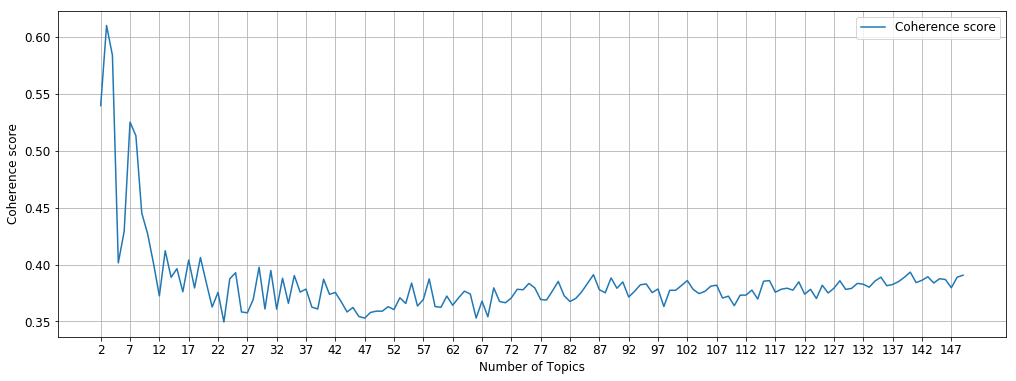

In [60]:
plt.plot(RNG, coherence_values, label='Coherence score')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.xticks(RNG[::5])
plt.legend()
plt.grid()
plt.show()

- 0.55 and above are good values for coherence scores
- 2,7 topics seems to be best

##### Optimal number of clusters

- Elbow method
- sihoulette value
    - measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation)
    - [-1,1]

In [76]:
lsa_test = TruncatedSVD(n_components=200, algorithm = 'arpack')
dtm_lsa_test = lsa_test.fit_transform(dtm)
dtm_lsa_test = Normalizer(copy=False).fit_transform(dtm_lsa_test) # normalisae so each vector is len 1

##### Important words for each Topic

In [77]:
features = vectorizer.get_feature_names()
topic_words = []
for i, comp in enumerate(lsa_test.components_):
    terms_comp = zip(features, comp)
    sorted_words = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    sorted_words_clean = [tup[0] for tup in sorted_words]
    topic_words.append(sorted_words_clean)
topic_df = pd.DataFrame(topic_words, index=['Topic '+str(i) for i in range(lsa_test.components_.shape[0])])

In [78]:
topic_df.head(50)

,0,1,2,3,4,5,6
Topic 0,solution,management,banking,insurance,commercial,business,gas
Topic 1,banking,investment,insurance,management,loan,financial,equity
Topic 2,gas,natural,electric,energy,electricity,mile,transmission
Topic 3,store,brand,food,insurance,care,home,retailer
Topic 4,insurance,life,health,benefit,group,care,plan
Topic 5,banking,care,treat,pharmaceutical,disease,treatment,equipment
Topic 6,insurance,equipment,vehicle,control,power,component,industrial
Topic 7,property,estate,real,investment,apartment,reit,community
Topic 8,banking,vehicle,network,treat,payment,entertainment,insurance
Topic 9,food,produce,television,network,discovery,fox,production


- words seem pretty sensible
- n_components is the number of topics to be extracted, so you shd use 64

# Determine Optimal Number of Clusters

In [79]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

gics_sil_score = silhouette_score(dtm_lsa_test, desc_df.GICS)

silhouette_coefficients = []
sse = []
iters = []
a,b = 2,200
for k in tnrange(a,b):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(dtm_lsa_test)
    score = silhouette_score(dtm_lsa_test, kmeans.labels_)
    silhouette_coefficients.append(score)
    sse.append(kmeans.inertia_)
    iters.append(kmeans.n_iter_) # dosent give much information usu from [4,20]


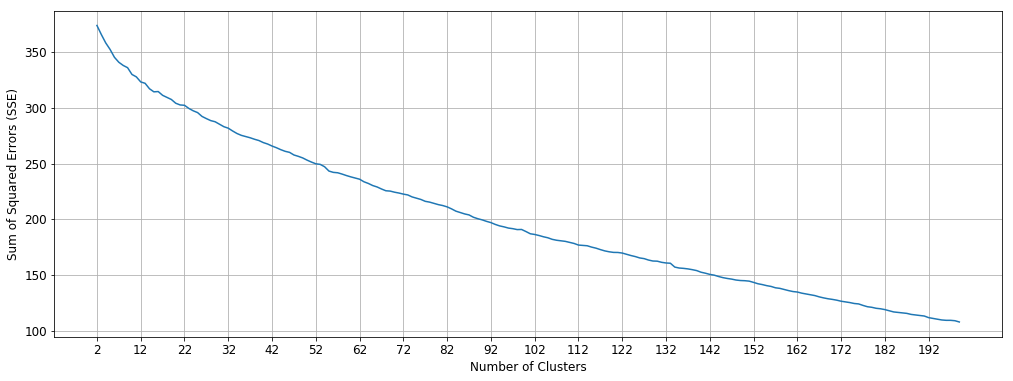

In [80]:
plt.plot(range(a, b), sse)
plt.xticks(range(a, b,10))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.grid()
plt.show()

- can see there is a slight elbow at 11

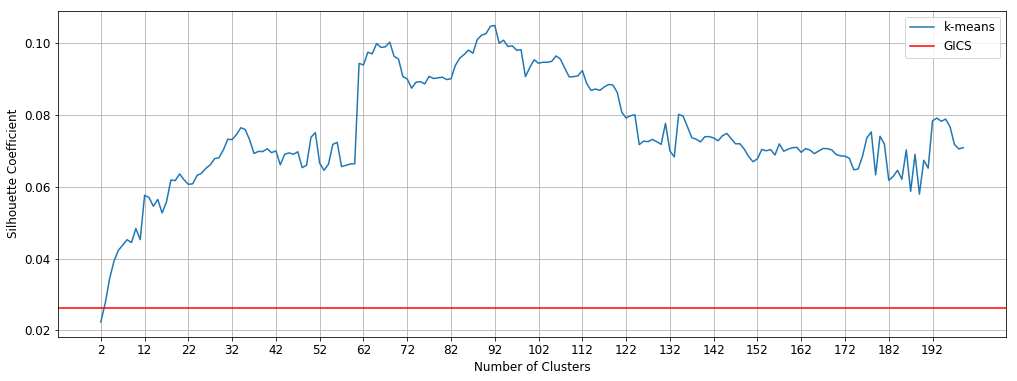

In [81]:
plt.plot(range(a,b), silhouette_coefficients, label='k-means')
plt.axhline(gics_sil_score, label='GICS', color='r')
plt.xticks(range(a,b,10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.legend()
plt.grid()
plt.show()

- best score at 112, which is the number of subindustries
- k-means easily outperforms GICS for silhouette coefficient, which makes sense as k-means is clustering wrt to the given vectors so it should in a sense optimise the silhouette coefficient

### Run all Clustering algos

In [132]:
dtms[0].shape

(454, 14583)

In [133]:
gics_df = pd.DataFrame(desc_dfs[0].GICS.cat.codes, columns=['GICS'])
cluster_dfs_list = [desc_dfs[0][['Ticker']], gics_df]
for i in range(len(DATA_SRCS)):
    data_src = DATA_SRCS[i]
    for k in tnrange(50, 401, 50):
        # LSI Embedding
        lsa_k = TruncatedSVD(k, algorithm = 'arpack')
        dtm_lsa_k = lsa_k.fit_transform(dtms[i])
        dtm_lsa_k = Normalizer(copy=False).fit_transform(dtm_lsa_k)
        # K-Means
        clusters_k = kmeans_cluster(dtm_lsa_k)
        cluster_dfs_list.append(pd.DataFrame(clusters_k, columns=['{}_lsi_{}_kmeans'.format(data_src, str(k))]))
        # GMM
        clusters_k = gmm_cluster(dtm_lsa_k)
        cluster_dfs_list.append(pd.DataFrame(clusters_k, columns=['{}_lsi_{}_gmm'.format(data_src, str(k))]))
        # Cosine_similarity
    
all_cluster = pd.concat(cluster_dfs_list, axis=1)

In [134]:
all_cluster

,Ticker,GICS,10K_lsi_50_kmeans,10K_lsi_50_gmm,10K_lsi_100_kmeans,10K_lsi_100_gmm,10K_lsi_150_kmeans,10K_lsi_150_gmm,10K_lsi_200_kmeans,10K_lsi_200_gmm,...,Reuters India_lsi_200_kmeans,Reuters India_lsi_200_gmm,Reuters India_lsi_250_kmeans,Reuters India_lsi_250_gmm,Reuters India_lsi_300_kmeans,Reuters India_lsi_300_gmm,Reuters India_lsi_350_kmeans,Reuters India_lsi_350_gmm,Reuters India_lsi_400_kmeans,Reuters India_lsi_400_gmm
0,A,43,1,25,0,2,0,27,21,25,...,52,51,53,18,36,47,37,4,46,33
1,AAL,17,30,37,17,16,9,23,10,24,...,13,25,56,12,0,3,33,31,17,25
2,AAP,31,55,49,11,32,4,4,29,3,...,29,53,44,45,11,49,2,11,23,6
3,AAPL,54,59,29,45,13,48,26,43,6,...,9,37,43,20,44,52,57,8,8,47
4,ABBV,41,11,36,4,40,53,0,18,15,...,8,44,8,6,6,23,9,1,6,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,YUM,26,35,59,34,54,39,14,25,40,...,20,37,25,5,55,43,4,8,2,1
450,ZBH,38,52,42,23,57,25,20,3,38,...,59,6,39,58,40,21,35,33,45,5
451,ZBRA,55,58,29,61,59,17,10,31,36,...,36,49,10,13,18,18,8,43,17,25
452,ZION,44,6,14,6,3,49,2,32,7,...,9,26,43,20,44,52,57,32,1,47


## Evaluation

### Method 1 - Ticker returns correlations

- regression of the daily return series of each stock with the return of the industry that the stock belongs to
- criterion is the the average of all R2s from the universe
- 5 years of daily returns used (same as previous project)

In [135]:
ticker_price_df = pd.read_csv('data_in/russell_price.csv', index_col=0) 
# Can use this path for SnP: 'data_out/ticker_price_df.csv'

In [136]:
ticker_price_df.columns = ticker_price_df.columns.str.replace('/', '-')
ticker_return_df = ticker_price_df.pct_change()
ticker_return_df

,A,AA,AAL,AAN,AAOI,AAON,AAP,AAPL,AAT,AAWW,...,ZION,ZIOP,ZIXI,ZNGA,ZS,ZTS,ZUMZ,ZUO,ZYNE,ZYXI
20150102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20150105,-0.018737,-0.057933,-0.000650,-0.003919,-0.012975,-0.033973,-0.013177,-0.028175,0.011396,-0.036555,...,-0.037468,-0.011696,-0.019718,-0.007326,1.062500,-0.006004,0.019105,0.428571,0.160714,-0.111803
20150106,-0.015577,0.007351,-0.015498,-0.037378,-0.037559,-0.015815,-0.000704,0.000093,0.007836,-0.021222,...,-0.038192,-0.021696,-0.025862,-0.003690,-0.154545,-0.009754,-0.012327,0.030000,0.188923,-0.062550
20150107,0.013273,0.025880,-0.000565,0.030317,-0.039024,0.009115,0.021485,0.014021,0.018955,0.017959,...,0.009356,0.012097,-0.002950,-0.007407,0.088889,0.020642,0.047322,0.000000,0.270186,-0.020018
20150108,0.029974,0.028461,0.012260,0.016196,0.011168,0.024715,0.008769,0.038426,0.005963,0.037220,...,0.014184,-0.005976,0.076923,-0.037313,0.023041,0.015398,0.027805,-0.050971,0.431948,-0.013616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20200518,0.025371,0.171171,0.091814,0.066134,0.024540,0.069529,0.040060,0.023561,0.066448,0.084015,...,0.119171,0.102041,0.032833,-0.009950,0.000000,0.030826,0.087572,0.000000,0.000000,0.000000
20200519,-0.020201,-0.007692,-0.023303,-0.032964,0.010778,-0.022518,0.035924,-0.005779,-0.034615,0.007802,...,-0.033730,-0.074074,0.019074,0.010050,0.000000,0.022219,-0.034716,0.000000,0.000000,0.000000
20200520,-0.003172,0.078811,0.023859,0.046173,0.020142,0.008213,-0.000736,0.019448,0.028287,0.028645,...,0.065024,0.080000,0.074866,0.012438,0.000000,-0.007444,-0.000999,0.000000,0.000000,0.000000
20200521,-0.011749,-0.008383,0.002026,-0.001777,0.005807,0.029009,-0.006852,-0.007455,0.004649,-0.006774,...,-0.012532,0.047138,0.023217,-0.000614,0.000000,-0.022574,0.092000,0.000000,0.000000,0.000000


In [137]:
# Tickers to remove if no ticker data
tickers_with_no_data = [ticker for ticker in all_cluster.Ticker if ticker not in ticker_return_df.columns]
print(tickers_with_no_data)

[]


In [138]:
all_cluster_filtered = all_cluster[~all_cluster.Ticker.isin(tickers_with_no_data)].reset_index(drop=True)
all_cluster_filtered.head()

,Ticker,GICS,10K_lsi_50_kmeans,10K_lsi_50_gmm,10K_lsi_100_kmeans,10K_lsi_100_gmm,10K_lsi_150_kmeans,10K_lsi_150_gmm,10K_lsi_200_kmeans,10K_lsi_200_gmm,...,Reuters India_lsi_200_kmeans,Reuters India_lsi_200_gmm,Reuters India_lsi_250_kmeans,Reuters India_lsi_250_gmm,Reuters India_lsi_300_kmeans,Reuters India_lsi_300_gmm,Reuters India_lsi_350_kmeans,Reuters India_lsi_350_gmm,Reuters India_lsi_400_kmeans,Reuters India_lsi_400_gmm
0,A,43,1,25,0,2,0,27,21,25,...,52,51,53,18,36,47,37,4,46,33
1,AAL,17,30,37,17,16,9,23,10,24,...,13,25,56,12,0,3,33,31,17,25
2,AAP,31,55,49,11,32,4,4,29,3,...,29,53,44,45,11,49,2,11,23,6
3,AAPL,54,59,29,45,13,48,26,43,6,...,9,37,43,20,44,52,57,8,8,47
4,ABBV,41,11,36,4,40,53,0,18,15,...,8,44,8,6,6,23,9,1,6,17


In [141]:
mtds_R2_list = []

for cluster_mtd in tqdm(all_cluster_filtered.columns):
    if cluster_mtd == 'Ticker':
        continue
    
    R2_list = []
    for i in range(NUM_INDUSTRIES):
        cluster_tickers = all_cluster_filtered[all_cluster_filtered[cluster_mtd] == i].Ticker
        cluster_ticker_returns = ticker_return_df[cluster_tickers]
        mean_return = cluster_ticker_returns.mean(axis=1)
        cluster_R2 = [mean_return.corr(ticker_returns) for _, ticker_returns in cluster_ticker_returns.iteritems()]
        R2_list.extend(cluster_R2)
    avg_R2 = sum(R2_list)/len(R2_list)
    if cluster_mtd == 'GICS':
        GICS_R2 = avg_R2
    else:
        data_src, _, k, clustering_mtd = cluster_mtd.split('_')
        mtds_R2_list.append([data_src, k, clustering_mtd, avg_R2])

avg_R2_df = pd.DataFrame(mtds_R2_list, columns=['Data_src', 'k', 'Clustering mtd', 'Average R2'])

In [145]:
avg_R2_df

,Data_src,k,Clustering mtd,Average R2
0,10K,50,kmeans,0.757855
1,10K,50,gmm,0.759964
2,10K,100,kmeans,0.755582
3,10K,100,gmm,0.753033
4,10K,150,kmeans,0.752132
5,10K,150,gmm,0.753080
6,10K,200,kmeans,0.749976
7,10K,200,gmm,0.749333
8,10K,250,kmeans,0.753075
9,10K,250,gmm,0.747318


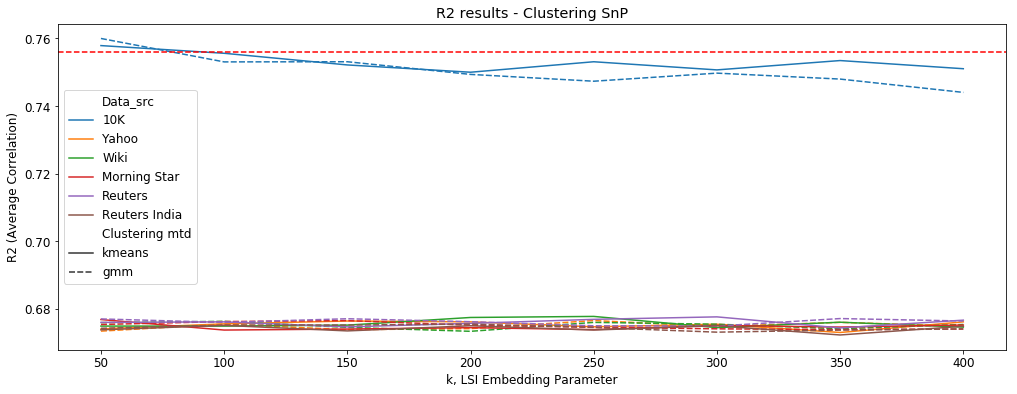

In [148]:
ax = sns.lineplot(data=avg_R2_df, x='k', y='Average R2', hue='Data_src', style='Clustering mtd', sort=False)
ax.axhline(GICS_R2, color="red", linestyle="--")
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='R2 (Average Correlation)', title='R2 results - Clustering SnP')
# plt.savefig('data_out/images/1_1.png')

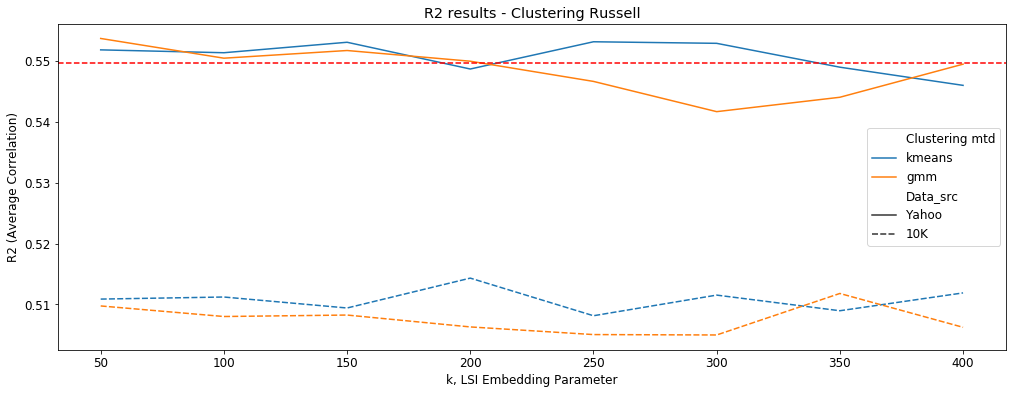

In [161]:
ax = sns.lineplot(data=avg_R2_df, x='k', y='Average R2', hue='Clustering mtd', style='Data_src', sort=False)
ax.axhline(GICS_R2, color="red", linestyle="--", label='GICS R2')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='R2 (Average Correlation)', title='R2 results - Clustering Russell')

### Method 2a - Inter Industry Variation of firm ratios

- The second criterion used is the across-industry variation (Hoberg and Phillips)
- Need to handle missing values of ratios
- in previous paper they removed outlier so higher score
- The higher the score the better

In [162]:
ticker_ratios_df = pd.read_csv('data_in/russell_ratios.csv')

In [163]:
def percentage_to_float(s):
    if type(s) == float:
        return s
    return float(s.strip('%').replace(',',''))/100

def mkt_cap_converter(s):
    if type(s) == float:
        return s
    multiplier = s[-1]
    if multiplier == 'M':
        return float(s[:-1])* 1000
    if multiplier == 'B':
        return float(s[:-1]) * 1000
    if multiplier == 'T':
        return float(s[:-1]) * 1000000
    else:
        raise Exception(s)
        
def pb_ratio_converter(s):
    if type(s) == float:
        return s
    multiplier = s[-1]
    if multiplier == 'k':
        return float(s[:-1]) * 1000
    else:
        return float(s)
    
def remove_commas(s):
    if type(s) == float:
        return s
    return float(s.replace(',',''))

In [ ]:
ticker_ratios_df.columns = ['Ticker', 'mkt_cap', 'pb_ratio', 'beta', 'profit_margin', 'ROA', 'ROE']

ticker_ratios_df.mkt_cap = ticker_ratios_df.mkt_cap.apply(mkt_cap_converter)
ticker_ratios_df.pb_ratio = ticker_ratios_df.pb_ratio.apply(pb_ratio_converter)
ticker_ratios_df.beta = ticker_ratios_df.beta.apply(remove_commas)
ticker_ratios_df.profit_margin = ticker_ratios_df.profit_margin.apply(percentage_to_float)
ticker_ratios_df.ROA = ticker_ratios_df.ROA.apply(percentage_to_float)
ticker_ratios_df.ROE = ticker_ratios_df.ROE.apply(percentage_to_float)

ticker_ratios_df

In [ ]:
# ticker_ratios_df = pd.read_csv('data_out/snp_ratios_df.csv', index_col=0)
# ticker_ratios_df

In [ ]:
# Normalise values
ticker_ratios_normalised_df = ticker_ratios_df.copy()
# for header in ticker_ratios_df.columns[1:]:
#     col = ticker_ratios_df[header]
#     ticker_ratios_normalised_df[header] = (col - col.mean())/col.std()
ticker_ratios_normalised_df

In [ ]:
# Tickers to remove if no ratio data
tickers_with_no_data = [ticker for ticker in all_cluster.Ticker if ticker not in list(ticker_ratios_df.Ticker)]
print(tickers_with_no_data)

In [ ]:
all_cluster_filtered = all_cluster[~all_cluster.Ticker.isin(tickers_with_no_data)].reset_index(drop=True)
all_cluster_filtered.head()

<font size="5">
$$
\sigma_v = \frac
                {\sqrt{\sum_{i=0}^{N} n_i \frac{v_m - v_i}{N}}}
                {\sqrt{\sum_{j=0}^{F} \frac{v_m - f_j}{N}}            }
$$
</font>

- $N$ - num industries
- $F$ - num firms
- $n_i$ - num firms in industry i
- $v_m$ - overall mean value of characteristic
- $v_i$ - mean value of characteristic in industry i
- $f_j$ - value of characteristic for firm j


- numerator is weighted average, while denomenator is simple average


- recheck method for Na values

In [ ]:
def cluster_variation(s):
    '''
    input: series
    output: sum(x - x_bar), sum of absolute distances to cluster center
    '''
    mean = s.mean() # ignores NaN values
    n  = s.count() # count non-NaN values
    variation = n * (v_m[s.name] - mean)**2
    return variation

In [ ]:
RATIO_NAMES_LIST = list(ticker_ratios_df.columns[1:])
all_cluster_with_ratio = pd.merge(all_cluster_filtered, ticker_ratios_normalised_df, on='Ticker')
ratio_variation_dict = {}

for cluster_mtd in tqdm(all_cluster_filtered.columns):
    if cluster_mtd == 'Ticker':
        continue
    filter_df = all_cluster_with_ratio[[cluster_mtd] + RATIO_NAMES_LIST]
    v_m = all_cluster_with_ratio[RATIO_NAMES_LIST].mean()
    variation_df = filter_df.groupby(cluster_mtd).aggregate(cluster_variation)
    variation_series = variation_df.sum()
    N_ratios = ticker_ratios_normalised_df[RATIO_NAMES_LIST].count() # count non-NaN values

    normaliser_series = ticker_ratios_normalised_df[RATIO_NAMES_LIST].std()

    sigma_v = list(np.sqrt(variation_series/N_ratios) / normaliser_series)
    ratio_variation_dict[cluster_mtd] = sigma_v

ratio_variation_df = pd.DataFrame.from_dict(ratio_variation_dict, orient='index', columns=RATIO_NAMES_LIST)
ratio_variation_df['Average Ratio Variation'] = ratio_variation_df.mean(axis=1)

In [ ]:
ratio_variation_df

In [ ]:
avg_ratio_df = ratio_variation_df[['Average Ratio Variation']]
GICS_RATIO = ratio_variation_df.loc['GICS', 'Average Ratio Variation']
MTDS = ['kmeans', 'gmm']
list_of_dfs = []

for mtd in MTDS:
    mtd_df = avg_ratio_df.filter(regex=mtd, axis=0)
    mtd_df.index = mtd_df.index.map(lambda s: s.split('_')[1])
    mtd_df.columns = [mtd]  #(columns = {'test':'TEST'}, inplace = True) 
    list_of_dfs.append(mtd_df)

avg_ratio_pivot_df = pd.concat(list_of_dfs, axis=1)
print(GICS_RATIO)
avg_ratio_pivot_df

In [ ]:
ax = sns.lineplot(data=avg_ratio_pivot_df, sort=False)
ax.axhline(GICS_RATIO, color="red", linestyle="--")
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Average Variation', title='Variation results - Clustering SnP using 10K reports')
plt.savefig('data_out/images/2_1.png')

In [ ]:
ax = sns.lineplot(data=avg_ratio_pivot_df, sort=False)
ax.axhline(GICS_RATIO, color="red", linestyle="--")
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Average Ratio', title='Variation results - Clustering SnP using yahoo desc')
plt.savefig('data_out/images/2_2.png')

In [ ]:
ax = sns.lineplot(data=avg_ratio_pivot_df, sort=False)
ax.axhline(GICS_RATIO, color="red", linestyle="--")
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Average Ratio', title='Variation results - Clustering Russell using 10K reports')
plt.savefig('data_out/images/2_3.png')

In [ ]:
ax = sns.lineplot(data=avg_ratio_pivot_df, sort=False)
ax.axhline(GICS_RATIO, color="red", linestyle="--")
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Average Ratio', title='Variation results - Clustering Russell using yahoo desc')
plt.savefig('data_out/images/2_4.png')

### Method 2b - Absolute distances to cluster center (my method)

- not a good guage i think

In [ ]:
def cluster_distance(s):
    '''
    input: series
    output: sum(x - x_bar), sum of absolute distances to cluster center
    '''
    mean = s.mean() #ignores NaN values
    abs_dist = abs(s-mean).sum()
    return abs_dist

In [ ]:
RATIO_NAMES_LIST = list(ticker_ratios_df.columns[1:])
all_cluster_with_ratio = pd.merge(all_cluster_filtered, ticker_ratios_normalised_df, on='Ticker')
ratio_distances_dict = {}

for cluster_mtd in tqdm(all_cluster_filtered.columns):
    if cluster_mtd == 'Ticker':
        continue
    
    filter_df = all_cluster_with_ratio[[cluster_mtd] + RATIO_NAMES_LIST]
    ratio_distance_sum = filter_df.groupby(cluster_mtd).aggregate(cluster_distance).sum()
    non_na_count_series = filter_df.count()[1:]
    ratio_distance_avg_list = list(ratio_distance_sum/non_na_count_series)
    ratio_distances_dict[cluster_mtd] = ratio_distance_avg_list
    
ratio_distances_df = pd.DataFrame.from_dict(ratio_distances_dict, orient='index', columns=RATIO_NAMES_LIST)

In [ ]:
ratio_distances_df['Average Ratio Cluster Spread'] = ratio_distances_df.mean(axis=1)
ratio_distances_df

In [ ]:
avg_ratio_df = ratio_distances_df[['Average Ratio Cluster Spread']]
GICS_RATIO = ratio_distances_df.loc['GICS', 'Average Ratio Cluster Spread']
MTDS = ['kmeans', 'gmm']
list_of_dfs = []

for mtd in MTDS:
    mtd_df = avg_ratio_df.filter(regex=mtd, axis=0)
    mtd_df.index = mtd_df.index.map(lambda s: s.split('_')[1])
    mtd_df.columns = [mtd]  #(columns = {'test':'TEST'}, inplace = True) 
    list_of_dfs.append(mtd_df)

avg_ratio_pivot_df = pd.concat(list_of_dfs, axis=1)
print(GICS_RATIO)
avg_ratio_pivot_df

In [ ]:
ax = sns.lineplot(data=avg_ratio_pivot_df, sort=False)
ax.axhline(GICS_RATIO, color="red", linestyle="--")
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Average Ratio')

### Method 2b - Financial Ratio average cluster distance (averaged by mkt cap)

### Method 3a - Similarity to GICS by probability (among ticker with same GICS classification)

- probability that if GICS classifies 2 elements in the same industry, they are in the same categorisation in the clustering method
- if you include same or different industry similarity, the similarity scores will be very high because most of the time the classifications will be different
- in this case you can do the first method because the number of classes is fixed, so you cant put all as the same class

In [ ]:
temp_df = pd.merge(all_cluster, all_cluster, on='GICS')
cross_df = temp_df[temp_df.Ticker_x != temp_df.Ticker_y]
similarity_dict = {}

for mtd in all_cluster.columns:
    if mtd not in ['Ticker', 'GICS']:
        mtd_x = mtd + '_x'
        mtd_y = mtd + '_y'
        similarity_dict[mtd] = sum(cross_df[mtd_x] == cross_df[mtd_y])/len(cross_df)

similarity_df = pd.DataFrame.from_dict(similarity_dict, orient='index', columns=['Similarity Probability'])

In [ ]:
MTDS = ['kmeans', 'gmm']
list_of_dfs = []

for mtd in MTDS:
    mtd_df = similarity_df.filter(regex=mtd, axis=0)
    mtd_df.index = mtd_df.index.map(lambda s: s.split('_')[1])
    mtd_df.columns = [mtd] 
    list_of_dfs.append(mtd_df)

similarity_pivot_df = pd.concat(list_of_dfs, axis=1)
similarity_pivot_df

In [ ]:
ax = sns.lineplot(data=similarity_pivot_df, sort=False)
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Similarity probability with GICS'
       , title='Similarity Probability results - Clustering SnP using 10K reports')
plt.savefig('data_out/images/3_1.png')

In [ ]:
ax = sns.lineplot(data=similarity_pivot_df, sort=False)
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Similarity probability with GICS'
       , title='Similarity Probability results - Clustering SnP using yahoo desc')
plt.savefig('data_out/images/3_2.png')

In [ ]:
ax = sns.lineplot(data=similarity_pivot_df, sort=False)
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Similarity probability with GICS'
       , title='Similarity Probability results - Clustering Russell using 10K reports')
plt.savefig('data_out/images/3_3.png')

In [ ]:
ax = sns.lineplot(data=similarity_pivot_df, sort=False)
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Similarity probability with GICS'
       , title='Similarity Probability results - Clustering Russell using yahoo desc')
plt.savefig('data_out/images/3_4.png')

### Method 3b - Similarity to GICS by probability of similar classification type among ANY 2 tickers

- takes much longer

In [ ]:
L = len(all_cluster)
similarity_series = pd.Series(0, all_cluster.columns)

for i in tnrange(L):
    for j in range(L):
        if i != j:
            similarity = (all_cluster.iloc[i] == all_cluster.iloc[j])
            if not similarity.GICS:
                similarity = ~similarity
            similarity_series += similarity.astype(int)

In [ ]:
similarity_df = pd.DataFrame((similarity_series/similarity_series.GICS)[2:], columns=['Similarity Probability'])

In [ ]:
MTDS = ['kmeans', 'gmm']
list_of_dfs = []

for mtd in MTDS:
    mtd_df = similarity_df.filter(regex=mtd, axis=0)
    mtd_df.index = mtd_df.index.map(lambda s: s.split('_')[1])
    mtd_df.columns = [mtd] 
    list_of_dfs.append(mtd_df)

similarity_pivot_df = pd.concat(list_of_dfs, axis=1)
similarity_pivot_df

In [ ]:
ax = sns.lineplot(data=similarity_pivot_df, sort=False)
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Similarity probability with GICS')

### Method 4 - Majority element ratios (my method)

In [ ]:
all_cluster.head()

In [ ]:
# Test
all_cluster[all_cluster.GICS == 3]

In [ ]:
def majority_element_proportion(s):
    '''
    input: series
    output: proportion of majority element in series
    '''
    l = len(s)
    n = s.value_counts().iloc[0]
    return n/l

In [ ]:
correctness_ratios_df = all_cluster.iloc[:,1:].groupby('GICS').aggregate(majority_element_proportion)

In [ ]:
correctness_ratios_df.plot.bar()
# sns.barplot(correctness_ratios_df)

In [ ]:
sns.distplot(correctness_ratios_df.iloc[:,0], bins=15)

- Since most of the ratios seem to be above the 0.5 ratio, the clustring seems to have clustered pretty closely to GICS standard

# Extra

### Old code

##### LSA Word Embedding (Test, Actual For loop is below)

In [ ]:
lsa = TruncatedSVD(200, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(dtm)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa) # normalisae so each vector is len 1

In [ ]:
pd.DataFrame(dtm_lsa).head()

##### K - Means

In [ ]:
# defining the kmeans function with initialization as k-means++
kmeans = KMeans(n_clusters=NUM_INDUSTRIES, init='k-means++')
# fitting the k means algorithm on scaled data
kmeans.fit(dtm_lsa)
pred = kmeans.predict(dtm_lsa)
# pd.concat([df[['company']], pd.DataFrame(pred)], axis=1).head()
pred

##### R2 Evaluation (longer code)

In [139]:
# R2_dict = {}

# for cluster_mtd in tqdm(all_cluster_filtered.columns):
#     if cluster_mtd == 'Ticker':
#         continue
    
#     R2_list = []
#     for i in range(NUM_INDUSTRIES):
#         cluster_tickers = all_cluster_filtered[all_cluster_filtered[cluster_mtd] == i].Ticker
#         cluster_ticker_returns = ticker_return_df[cluster_tickers]
#         mean_return = cluster_ticker_returns.mean(axis=1)
#         cluster_R2 = [mean_return.corr(ticker_returns) for _, ticker_returns in cluster_ticker_returns.iteritems()]
#         R2_list.extend(cluster_R2)
#     avg_R2 = sum(R2_list)/len(R2_list)
#     R2_dict[cluster_mtd] = avg_R2

# avg_R2_df = pd.DataFrame.from_dict(R2_dict, orient='index', columns=['Average R2'])

In [140]:
# GICS_R2 = R2_dict['GICS']
# MTDS = ['kmeans', 'gmm']
# list_of_dfs = []

# for mtd in MTDS:
#     mtd_df = avg_R2_df.filter(regex=mtd, axis=0)
#     mtd_df.index = mtd_df.index.map(lambda s: s.split('_')[1])
#     mtd_df.columns = [mtd]  #(columns = {'test':'TEST'}, inplace = True) 
#     list_of_dfs.append(mtd_df)

# avg_R2_pivot_df = pd.concat(list_of_dfs, axis=1)
# print(GICS_R2)
# avg_R2_pivot_df

### Random

##### Cosine Similarity

In [ ]:
# Plotting for 2D
%pylab inline

xs = [w[0] for w in dtm_lsa]
ys = [w[1] for w in dtm_lsa]
xs, ys

figure()
plt.scatter(xs,ys)
xlabel('First principal component')
ylabel('Second principal component')
title('Plot of points against LSA principal components')

In [ ]:
def cosine_similarity(dtm):
    '''
    input: Doc Matrix
    output: list of lists indicating clusters
    '''
    corr = np.asarray(numpy.asmatrix(dtm_lsa) * numpy.asmatrix(dtm_lsa).T)
    
    L = dtm.shape[0]
    clusters = [[i] for i in range(L)]
    
    while (len(clusters) != NUM_INDUSTRIES):
        L = len(clusters)
        max_similarity = -1
        max_similarity_clusters = (None, None)
        for i in range(L):
            for j in range(i+1,L):
                cluster_1 = clusters[i]
                cluster_2 = clusters[j]
                n = len(cluster_1) * len(cluster_2)
                
                # Similarity
                total_similarity = 0
                for cpy_1 in cluster_1:
                    for cpy_2 in cluster_2:
                        print(cpy_1, cpy_2)
                        total_similarity += corr[cpy_1][cpy_2]
                similarity = total_similarity / n
                
                if similarity > max_similarity:
                    max_similarity = similarity 
                    max_similarity_clusters = (i, j)
        
        # Merge max_similarity clusters
        cluster_merge = clusters.pop(max_similarity_clusters[1])
        clusters[max_similarity_clusters[0]].append(cluster_merge)
        print(L)
    return clusters

|Embedding model|R2|proportion of right classification|
|----------------|--------|--------|
| LSI length 200 | 0.4537 | 0.4962 |
| LSI length 300 | 0.4459 | 0.4768 |
| LSI length 400 | 0.4421 | 0.4072 |
| LSI length 500 | 0.4554 | 0.4244 |
| LSI length 600 | 0.4362 | 0.4409 |
| LSI length 700 | 0.4407 | 0.3842 |
| LSI length 800 | 0.4417 | 0.4921 |
| LSI length 900 | 0.4478 | 0.4005 |
| LSI length 1000 | 0.4403 | 0.4068 |
| LSI length 1100 | 0.4380 | 0.3933 |